In [1]:
!pwd
isLocalServer = True

/notebook


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

def path_add_to_sys_path(path_to_be_add):
  # path_to_be_add = '/notebook/personal/ksuchoi216/face-id-model/'
  if not path_to_be_add in sys.path:
    sys.path.insert(0, path_to_be_add)
    os.chdir(path_to_be_add)

  print(f'sys.path: {sys.path}')

if isLocalServer is True:
  path_add_to_sys_path('/notebook/personal/ksuchoi216/faceID-model/')
  
from utils import load_config
cfg = load_config('config_pca.json')

sys.path: ['/notebook/personal/ksuchoi216/faceID-model/', '/notebook', '/root/.pyenv/versions/3.9.1/lib/python39.zip', '/root/.pyenv/versions/3.9.1/lib/python3.9', '/root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload', '', '/root/.pyenv/versions/python39/lib/python3.9/site-packages']


NameError: name 'dataframe' is not defined

# Loading model and data

In [ ]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['embedding'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

phase="train"
for i, (img, label) in enumerate(dataloaders[phase]):
  if i >= 3:
    break
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(f'label: {label}')  

In [ ]:
from modules import Builder
import torchsummary

cfg = load_config('config_pca.json')
builder_classification = Builder(cfg['model_for_classification'])
builder_embedding = Builder(cfg['model_for_embedding'])
model_for_classification = builder_classification.loadModel('./data/face-extraction-model.pt', 'cpu')
model_for_embedding = builder_embedding.getModel('cpu').eval()
print(model_for_embedding)

# Feature extraction and data transfromation

In [5]:
from external_library import MTCNN
face_detector = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40)


from utils import imshow_denormalization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# phases = ['train', 'val', 'test']
phases = ['test']
for phase in phases:
  print(f'phase: {phase}')
  
  image_list = []
  model_preds_list = []
  model_embs_list = []
  label_list = []
  
  for i, (img, label) in enumerate(dataloaders[phase]):
    face, _ = face_detector(img, return_prob = True)
    # print(face.shape)
    
    if face is not None:
      prods = model_for_classification(face)
      prods = torch.sigmoid(prods)
      _, pred = torch.max(prods, 1)
      pred = pred.numpy()
      
      # face = torch.squeeze(face)
      emb = model_for_embedding(face)
      emb = torch.squeeze(emb).numpy()
      
      if emb.shape[0] != 512:
        print(f'dimension errror - output.shape: {emb.shape[0]}')
      
      face = torch.squeeze(face).view(-1,).numpy()
              
      image_list.append(face)
      model_preds_list.append(pred)
      model_embs_list.append(emb)
      label_list.append(label)
  
    print(f'{i:4}... img shape: {face.shape} pred shape: {pred.shape} emb shape: {emb.shape} label: {label}')  
  
  path_for_image_data = './data/'+phase+'_image.npy'
  path_for_pred_data = './data/'+phase+'_pred.npy'
  path_for_emb_data = './data/'+phase+'_emb.npy'
  path_for_label_data = './data/'+phase+'_label.npy'
  
  image_numpy = np.array(image_list)
  pred_numpy = np.array(model_preds_list)
  emb_numpy = np.array(model_embs_list)
  label_numpy = np.array(label_list)
  
  np.save(path_for_image_data, image_numpy, allow_pickle=True)
  np.save(path_for_pred_data, pred_numpy, allow_pickle=True)
  np.save(path_for_emb_data, emb_numpy, allow_pickle=True)
  np.save(path_for_label_data, label_numpy, allow_pickle=True)
  # print(len(data_list))
  print(f'{phase}_image.npy saved in {path_for_image_data}')
  print(f'{phase}_pred.npy saved in {path_for_pred_data}')
  print(f'{phase}_emb.npy saved in {path_for_emb_data}')
  print(f'{phase}_label.npy saved in {path_for_label_data}')
  
  print('\n')  

ModuleNotFoundError: No module named 'external_library'

In [ ]:
phase = phases[0]

source = './data/'
path_x_img = source + phase + '_image.npy'
x_img = np.load(path_x_img, allow_pickle=True)


path_x_pred = source + phase +'_pred.npy'
x_pred = np.load(path_x_pred, allow_pickle=True)

path_x_emb = source + phase +'_emb.npy'
x_emb = np.load(path_x_emb, allow_pickle=True)

path_y = source + phase + '_label.npy'
y = np.load(path_y, allow_pickle=True)

# val_path = source + 'val.npy'
# test_path = source + 'test.npy'


print(f'images shape: {x_img.shape} pred: {x_pred.shape} embedding: {x_emb.shape} y: {y.shape}')

# PCA

In [3]:
#multiple numpy to dataframe
import pandas as pd
from utils import pca

combined_arrray = np.column_stack((pca1, pca2, true, pred, error))
data_for_pca = pd.DataFrame(combined_array, columns = ['pca1','pca2','true', 'pred', 'error'])

pca_x1, pca_x2 = execute_pca(data_for_pca)

ModuleNotFoundError: No module named 'utils'

In [72]:
from utils import show_pca, show_pca_with_prediction
label_list = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
show_pca(x_img, y, label_list)

ImportError: cannot import name 'show_pca_with_prediction' from 'utils' (/notebook/personal/ksuchoi216/face-id-model/utils/__init__.py)

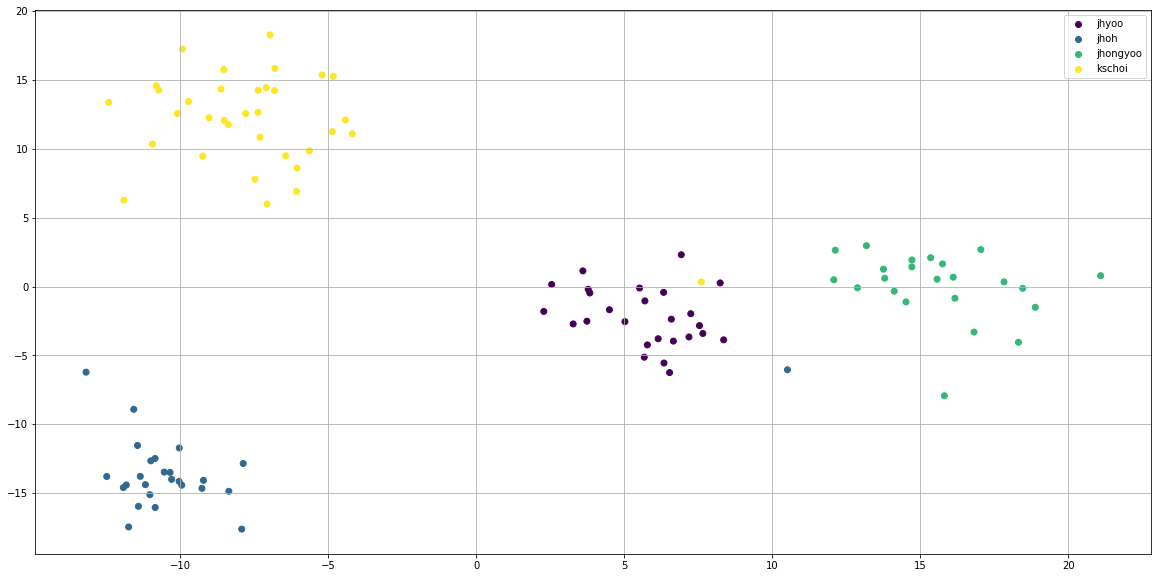

In [73]:
label_list = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
show_pca(x_emb, y, label_list)